In [235]:
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Dict
import re
import orjson as json
from collections import defaultdict
import numpy as np
from pprint import pprint

In [236]:
DPI=300

In [237]:
def parse_event(string: str):
    data = {}
    substrings = re.findall(r'\[.*?\]', string)
    for substring in substrings:
        substring = substring[1:-1]
        key, value = tuple(substring.split(':'))
        data[key.strip()] = value.strip()
    return data

def get_events_client(quiche_host_logs: str):
    data = {
        'topic': defaultdict(lambda: defaultdict(list)),
    }
    with open(quiche_host_logs, 'r') as f:
        lines = f.readlines()
    for line in lines:
        line = line.strip()
        if "[PARSE_EVENT]" in line:
            event = parse_event(line.split("[PARSE_EVENT]")[1])
            data['topic'][event['topic']][event['event']].append(event)
    return data


In [238]:
spin_data = get_events_client("../local_measurements/spin_client.log")
mutex_data = get_events_client("../local_measurements/client.log")

In [239]:
def get_locking_events(data: dict):
    return data['topic']['locking']

def plot_locking_events(ax: plt.Axes, data: dict):
    data = get_locking_events(data)
    labels, data_to_plot = [], []   
    for event_name, values in data.items():
        labels.append(event_name)
        data_to_plot.append([int(ev_data['value']) for ev_data in values if ev_data['type'] == 'duration'])
    for i in range(len(data_to_plot)):
        print(f"Event {labels[i]}")
        print(f"\t Mean: {np.mean(data_to_plot[i])} ns")
        print(f"\t Median: {np.median(data_to_plot[i])} ns")
        print(f"\t Std: {np.std(data_to_plot[i])} ns")
    ax.bar(labels, height=[np.mean(x) for x in data_to_plot], yerr=[np.std(x) for x in data_to_plot], capsize=4, zorder=3)
    ax.set_ylim(bottom=0)
    ax.set_xticklabels(labels, rotation=30)
    ax.grid(which='major', zorder=0, linestyle="dashed")
    ax.set_ylabel('Average Duration (ns)')

def plot_compare_locking(spin_lock: dict, mutex: dict):
    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 4), dpi=DPI, layout="constrained")
    spin_lock = get_locking_events(spin_lock)
    mutex = get_locking_events(mutex)
    spin_labels = {}
    for event_name, values in spin_lock.items():
        spin_labels[event_name] = [int(ev_data['value']) for ev_data in values if ev_data['type'] == 'duration']

    mutex_labels = {}
    for event_name, values in mutex.items():
        mutex_labels[event_name] = [int(ev_data['value']) for ev_data in values if ev_data['type'] == 'duration']
    
    labels = [] 
    avg_spins, avg_mutex = [], []
    std_spins, std_mutex = [], []

    assert set(spin_labels.keys()) == set(mutex_labels.keys())

    for event in spin_labels.keys():
        labels.append(event)
        avg_spins.append(np.mean(spin_labels[event]))
        avg_mutex.append(np.mean(mutex_labels[event]))
        std_spins.append(np.std(spin_labels[event]))
        std_mutex.append(np.std(mutex_labels[event]))

    x = np.arange(len(labels))
    width = 0.35
    padding = 0.05
    ax.bar(x, avg_spins, width, zorder=3, yerr=std_spins, label="Spin Lock")
    ax.bar(x + (1*width) + padding, avg_mutex, width, zorder=3, yerr=std_mutex, label="Mutex Lock")

    ax.set_yscale('log')
    ax.set_xticks(x + width, labels, rotation=90)
    ax.grid(which='major', zorder=0, linestyle="dashed")
    ax.set_ylabel('Average Duration (ns)')
    ax.legend()

['UDP Rcv Packets', 'Acquire Rcv Lock', 'Conn Rcv CS', 'Conn + UDP Snd CS', 'Acquire HTTP Lock', 'HTTP CS']


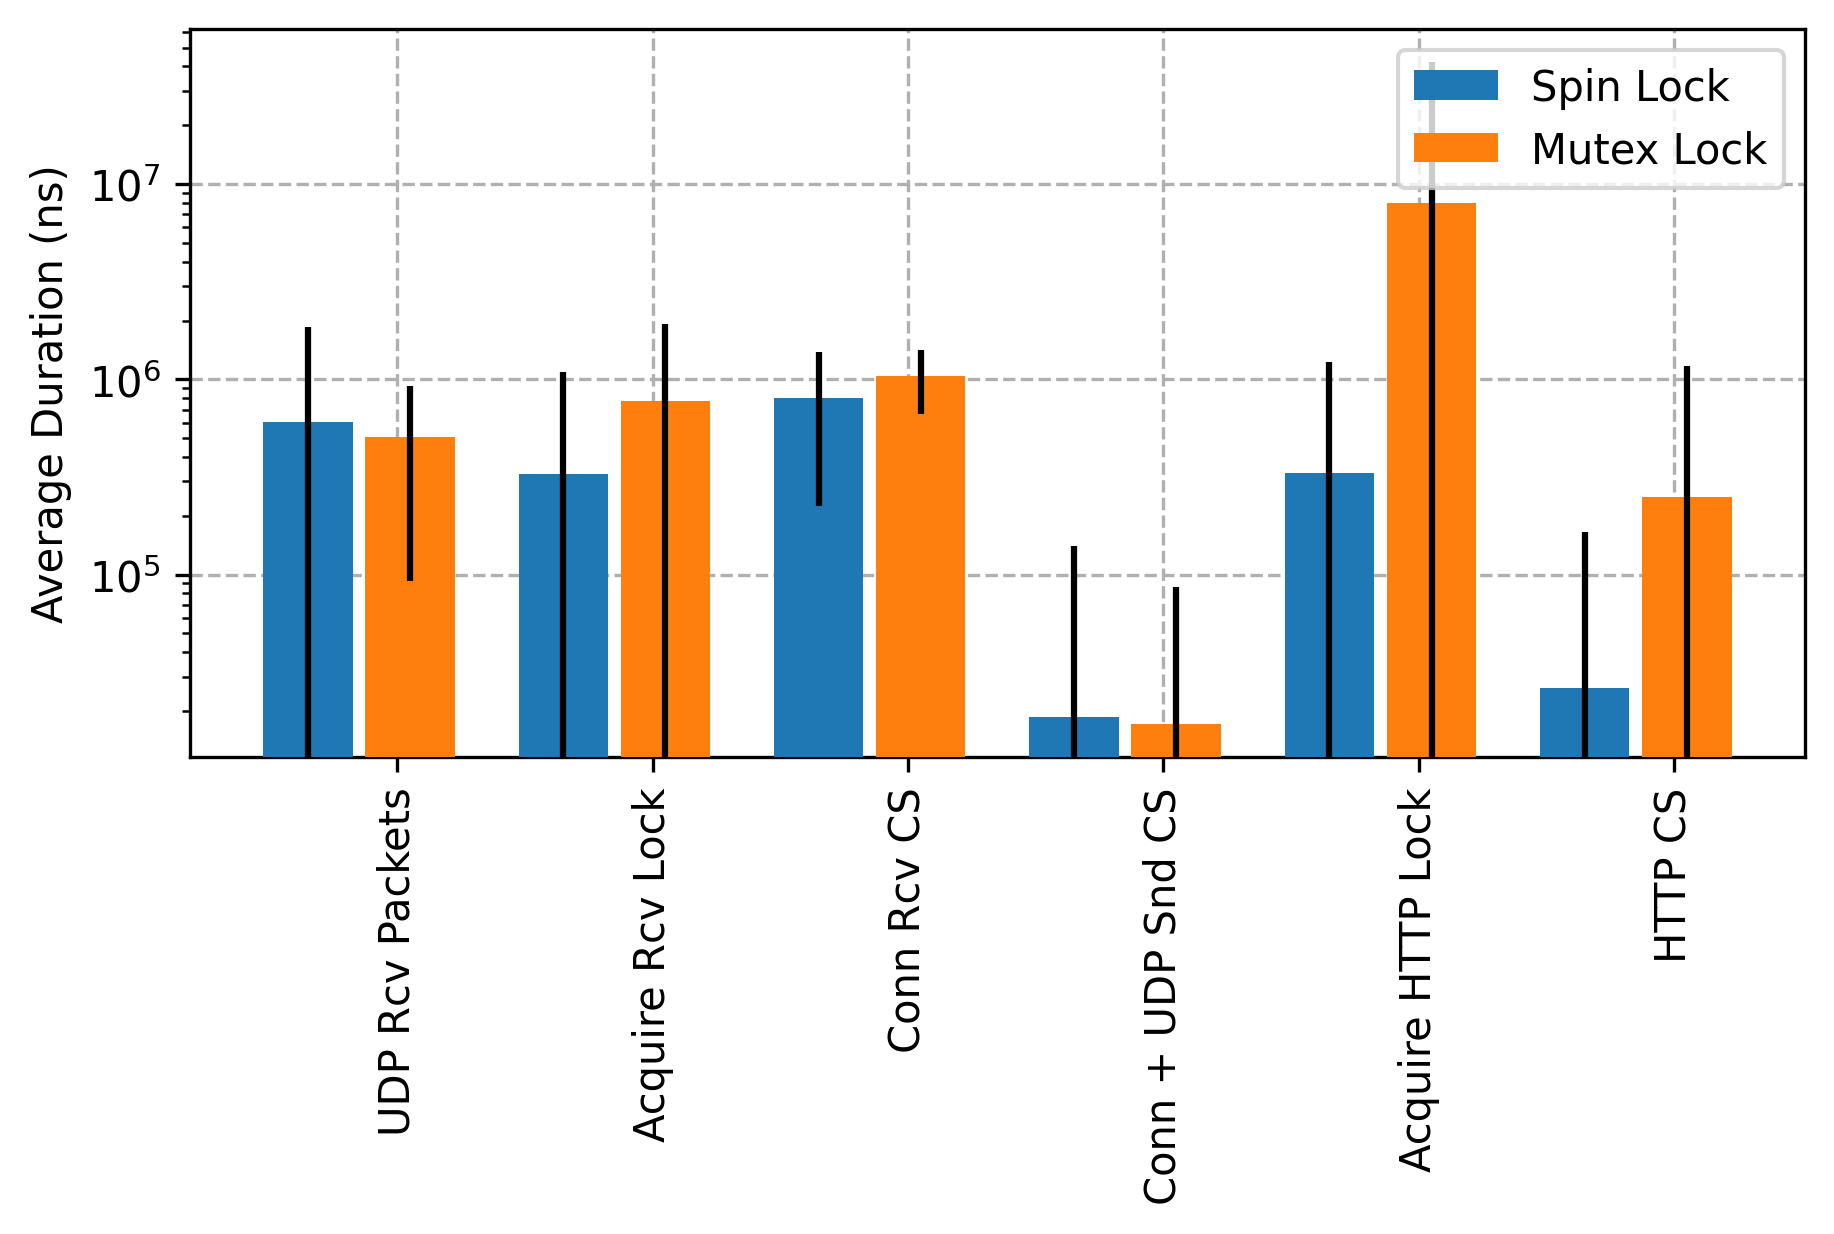

In [240]:
plot_compare_locking(spin_data, mutex_data)
plt.show()